In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
import copy

# Set data folder path
files_path = "DataFiles/"

In [2]:
px = pd.read_csv("DataFiles/priceData.csv")
px = px.dropna() # Remove NaN entries which cause graphs to be incomplete
px['date'] = pd.to_datetime(px['date'], dayfirst=True)
px.set_index(['date'], inplace=True)
logpx = px.copy()
logpx['SPX Index'] = np.log(logpx['SPX Index'])


<AxesSubplot:title={'center':'Log SPX Index'}, xlabel='Date'>

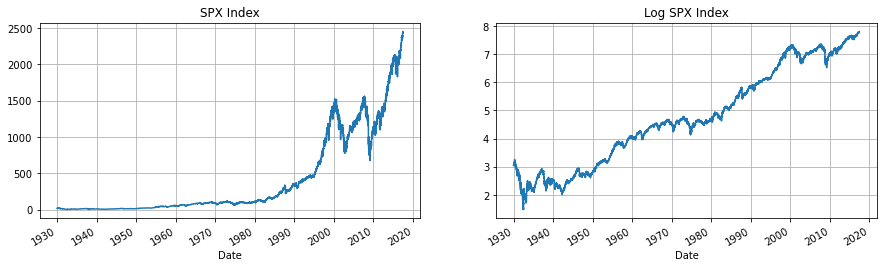

In [3]:
fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

px.plot(ax=axes[0], grid=True, title='SPX Index', legend=False, xlabel='Date')
logpx.plot(ax=axes[1], grid=True, title='Log SPX Index', legend=False, xlabel='Date')

<AxesSubplot:title={'center':'Log SPX Index | Sliding Window | mean'}, xlabel='Date'>

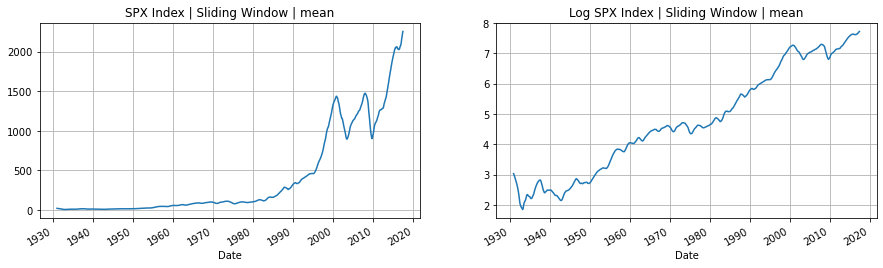

In [4]:
# Size of sliding window
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)


px.rolling(window).mean().plot(ax=axes[0], grid=True, title='SPX Index | Sliding Window | mean', legend=False, xlabel='Date')
logpx.rolling(window).mean().plot(ax=axes[1], grid=True, title='Log SPX Index | Sliding Window | mean', legend=False, xlabel='Date')

<AxesSubplot:title={'center':'Log SPX | Index Sliding Window | s.d.'}, xlabel='Date'>

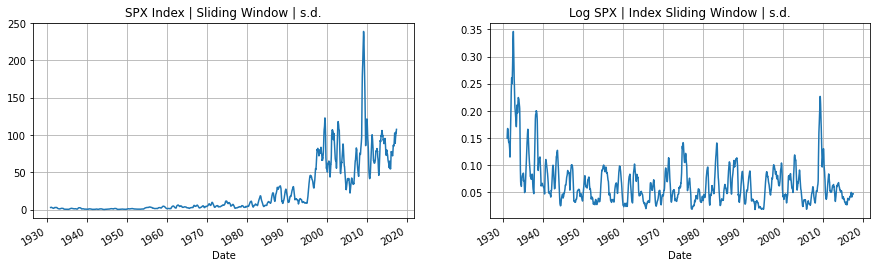

In [5]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)
px.rolling(window).std().plot(ax=axes[0], grid=True, title='SPX Index | Sliding Window | s.d.', legend=False, xlabel='Date')
logpx.rolling(window).std().plot(ax=axes[1], grid=True, title='Log SPX | Index Sliding Window | s.d.', legend=False, xlabel='Date')

<AxesSubplot:title={'center':'Log SPX Index'}, xlabel='Date'>

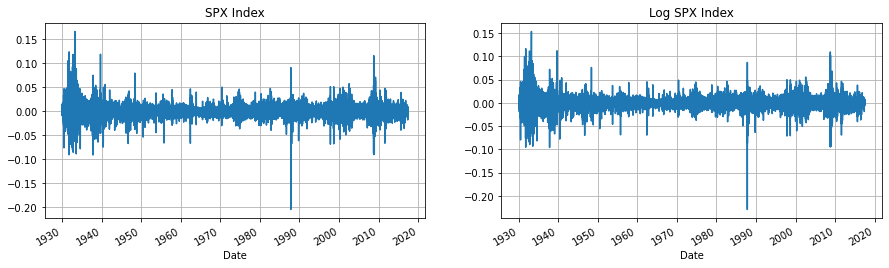

In [6]:
logret = logpx.copy()
logret['SPX Index'] = logret['SPX Index'].diff()

simret = px.copy()
simret['SPX Index'] = simret['SPX Index'].pct_change()

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

simret.plot(ax=axes[0], grid=True, title='SPX Index', legend=False, xlabel='Date')
logret.plot(ax=axes[1], grid=True, title='Log SPX Index', legend=False, xlabel='Date')

<AxesSubplot:title={'center':'SPX Index | Log Returns | Sliding Window | mean'}, xlabel='Date'>

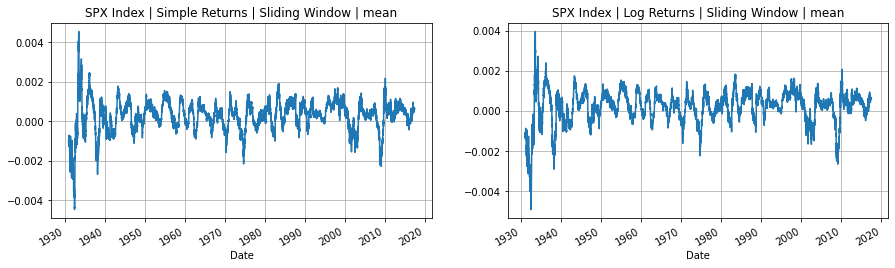

In [7]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)
simret.rolling(window).mean().plot(ax=axes[0], grid=True, title='SPX Index | Simple Returns | Sliding Window | mean', legend=False, xlabel='Date')
logret.rolling(window).mean().plot(ax=axes[1], grid=True, title='SPX Index | Log Returns | Sliding Window | mean', legend=False, xlabel='Date')

<AxesSubplot:title={'center':'SPX Index | Log Returns | Sliding Window | s.d.'}, xlabel='Date'>

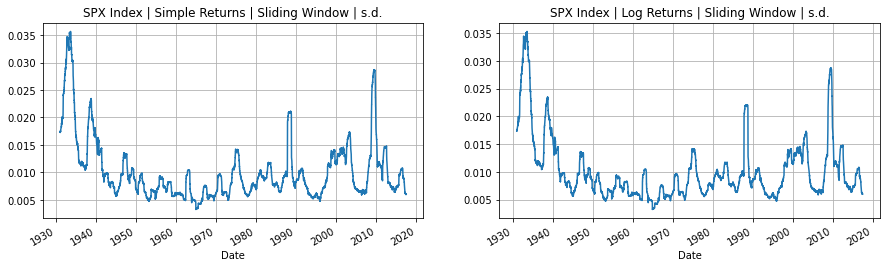

In [8]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

simret.rolling(window).std().plot(ax=axes[0], grid=True, title='SPX Index | Simple Returns | Sliding Window | s.d.', legend=False, xlabel='Date')
logret.rolling(window).std().plot(ax=axes[1], grid=True, title='SPX Index | Log Returns | Sliding Window | s.d.', legend=False, xlabel='Date')

In [9]:
# Do some jarque-bera tests

# ARMA & ARIMA

In [10]:
# ARMA vs ARIMA
snp = pd.read_csv(files_path+'snp_500_2015_2019.csv')
snp['Date'] = pd.to_datetime(snp['Date'], dayfirst=True)
snp.set_index(['Date'], inplace=True)
snp_close = snp['Close'].to_frame()
snp_log_close = snp['Close'].to_frame().apply(np.log)

<AxesSubplot:title={'center':'S&P 500 | Closing Value'}, xlabel='Date'>

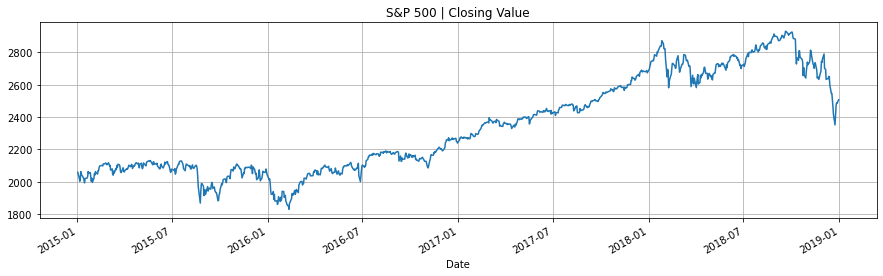

In [11]:
fig, axes = plt.subplots(1)
fig.set_figwidth(15)
snp_close.plot(ax=axes, grid=True, title='S&P 500 | Closing Value', legend=False, xlabel='Date')

In [12]:
snp_logret = snp_log_close.copy()
snp_logret['Close'] = snp_logret['Close'].diff()

snp_simret = snp_close.copy()
snp_simret['Close'] = snp_simret['Close'].pct_change()

<AxesSubplot:title={'center':'S&P 500 | Log Returns | Sliding Window | mean'}, xlabel='Date'>

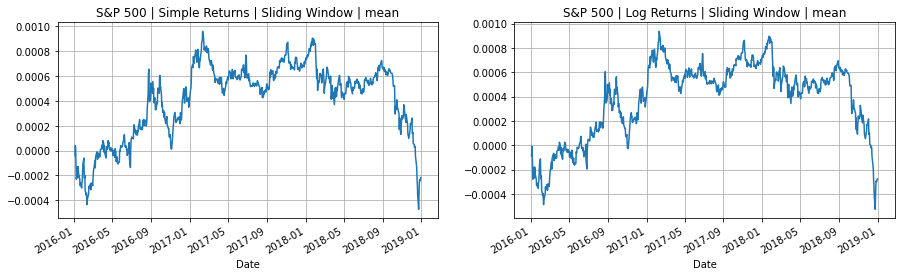

In [13]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)
# axes[0].set_xticklabels([])
# axes[0].set_xlabel("Date")
# axes[1].set_xticklabels([])
# axes[1].set_xlabel("Date")

snp_simret.rolling(window).mean().plot(ax=axes[0], grid=True, title='S&P 500 | Simple Returns | Sliding Window | mean', legend=False)
snp_logret.rolling(window).mean().plot(ax=axes[1], grid=True, title='S&P 500 | Log Returns | Sliding Window | mean', legend=False)

<AxesSubplot:title={'center':'S&P 500 | Log Returns | Sliding Window | s.d.'}, xlabel='Date'>

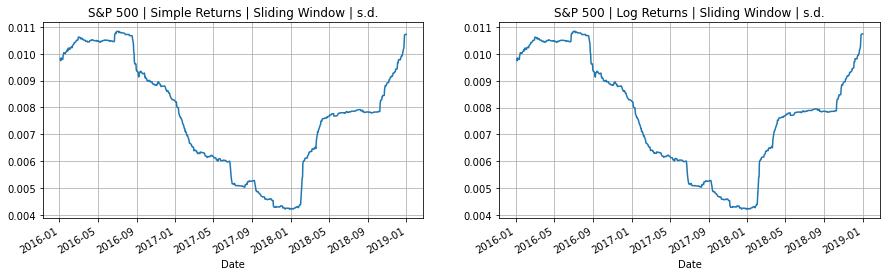

In [14]:
window = 252

fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)
# axes[0].set_xticklabels([])
# axes[0].set_xlabel("Date")
# axes[1].set_xticklabels([])
# axes[1].set_xlabel("Date")

snp_simret.rolling(window).std().plot(ax=axes[0], grid=True, title='S&P 500 | Simple Returns | Sliding Window | s.d.', legend=False)
snp_logret.rolling(window).std().plot(ax=axes[1], grid=True, title='S&P 500 | Log Returns | Sliding Window | s.d.', legend=False)

Model Parameters:  [0.99743446]


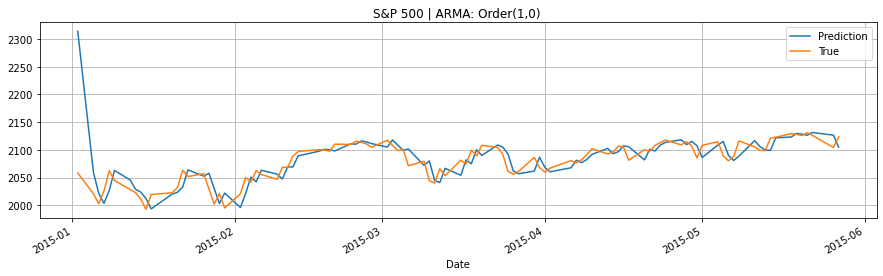

In [15]:
snp_arma = snp_close.copy()
snp_arma.columns = ['True']
snp_arma['Res'] = ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().resid
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

fig, axes = plt.subplots(1)
fig.set_figwidth(15)

snp_arma[:100].plot(ax=axes, grid=True, title='S&P 500 | ARMA: Order(1,0) ', y=['Prediction','True'])

print('Model Parameters: ', ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().arparams)

Model Parameters:  [-0.00675003]


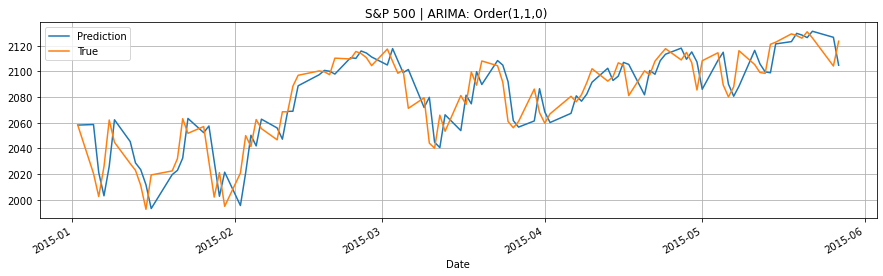

In [16]:
snp_arima = snp_close.copy()
snp_arima.columns = ['True']
snp_arima['Res'] = np.concatenate((np.array([0]),ARIMA(snp_arima['True'].values, order=(1,1,0)).fit().resid))
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

fig, axes = plt.subplots(1)
fig.set_figwidth(15)

snp_arima[:100].plot(ax=axes, grid=True, title='S&P 500 | ARIMA: Order(1,1,0) ', y=['Prediction','True'])

print('Model Parameters: ', ARIMA(snp_arima['True'].values, order=(1,1,0)).fit().arparams)

# VAR

## Portfolio Analysis

In [17]:
all_stocks = pd.read_csv(files_path+'snp_allstocks_2015_2019.csv')

all_stocks['Date'] = pd.to_datetime(all_stocks['Date'], dayfirst=True)
all_stocks.set_index(['Date'], inplace=True)

info = pd.read_csv(files_path+'snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)

In [18]:
tickers = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT'] # What we're interested in
stocks = all_stocks[tickers]

# Detrend using a moving average of 66 (3*22 i.e. one quarter)
stocks_ma = stocks.rolling('66d').mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

# Create model
model = VAR(stocks_detrended)
results = model.fit(1)
A =  results.params[1:].values
eigA, _ = np.linalg.eig(A)

C:\Users\naim\miniconda3\envs\spmlf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [19]:
results.params[1:]

,CAG,MAR,LIN,HCP,MAT
L1.CAG,0.974777,0.039232,-0.123425,0.016729,0.017966
L1.MAR,-0.005315,0.911080,-0.050244,-0.011322,0.004972
L1.LIN,0.012038,-0.036269,0.831307,-0.004252,-0.015392
L1.HCP,-0.055927,0.030390,-0.243046,0.909823,-0.021972
L1.MAT,0.070240,-0.010227,0.504571,0.031416,0.972620


<AxesSubplot:title={'center':'Detrended Stock Value | Sliding Window | Mean'}, xlabel='Date'>

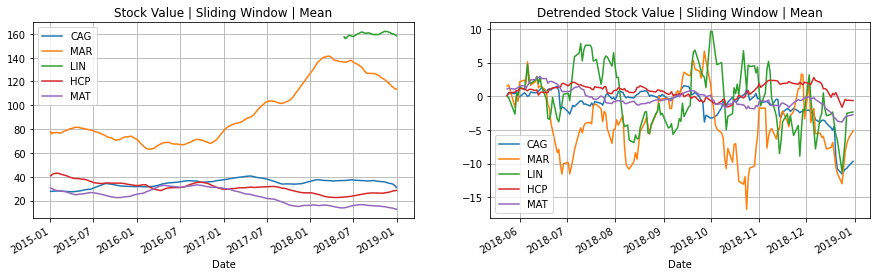

In [20]:
fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)



stocks_ma.plot(ax=axes[0], grid=True, title='Stock Value | Sliding Window | Mean')
stocks_detrended.plot(ax=axes[1], grid=True, title='Detrended Stock Value | Sliding Window | Mean')

In [21]:
for sector in info['GICS Sector'].unique():
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = all_stocks[tickers].dropna()


In [22]:
eigA

array([0.99236412+0.j        , 0.91603019+0.07512617j,
       0.91603019-0.07512617j, 0.84879552+0.j        ,
       0.92638625+0.j        ])